In [1]:
import torch
import numpy as np
import os

import time

import sys
sys.path.append("src/")

from qcd_ml.nn.lptc import v_LPTC
from qcd_ml.qcd.dirac import dirac_wilson_clover
#from qcd_ml.compat.gpt import lattice2ndarray, ndarray2lattice
from qcd_ml.util.solver import GMRES_torch
from qcd_ml.util.qcd.multigrid import ZPP_Multigrid
from qcd_ml.base.paths import v_evaluate_path, v_ng_evaluate_path, v_reverse_evaluate_path, PathBuffer
from qcd_ml.base.operations import v_spin_transform, v_ng_spin_transform, v_gauge_transform

from qcd_ml_accel.pool4d import v_pool4d, v_unpool4d

vec = torch.complex(
        torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
        , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))

U = torch.tensor(np.load(os.path.join("test", "assets","1500.config.npy")))

U_smeared = torch.load("U_smeared.pt")
U_smeared = [torch.tensor(np.array(Us)) for Us in U_smeared]

import itertools
def get_paths_lexicographic(block_size):
    paths = []
    for position in itertools.product(*(range(bs) for bs in block_size)):
        path = sum([[(mu, -1)] for mu, n in enumerate(position) for _ in range(n)], start=[])
        paths.append(path)
    return paths

def get_paths_reverse_lexicographic(block_size):
    return [list(reversed(pth)) for pth in get_paths_lexicographic(block_size)]

def get_paths_one_step_lexicographic(block_size):
    paths = []
    for position in itertools.product(*(range(bs) for bs in block_size)):
        path = []
        pos = np.array(position)
        while pos.any():
            for mu in range(pos.shape[0]):
                if pos[mu] > 0:
                    path.append((mu, -1))
                    pos[mu] -= 1
        paths.append(path)
    return paths
def get_paths_one_step_reverse_lexicographic(block_size):
    return [list(reversed(pth)) for pth in get_paths_one_step_lexicographic(block_size)]


def path_get_orig_point(path):
    point = [0] * 4
    for mu, nhops in path:
        point[mu] -= nhops
    return point



/tmp/ipykernel_67975/153761180.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  U_smeared = torch.load("U_smeared.pt")


In [2]:
class v_ProjectLayer(torch.nn.Module):
    def __init__(self, gauges_and_paths, L_fine, L_coarse):
        super().__init__()
        self.path_buffers = [[PathBuffer(Ui, pij) for pij in pi] for Ui, pi in gauges_and_paths]
        self.weights = torch.nn.Parameter(
                torch.randn(len(gauges_and_paths), *tuple(U.shape[1:-2]), 4, 4, dtype=torch.cdouble)
                )
        self.L_fine = L_fine
        self.L_coarse = L_coarse
        self.block_size = torch.tensor([lf // lc for lf, lc in zip(L_fine, L_coarse)], dtype=torch.int64)

        self.base_points = np.array([[path_get_orig_point(pb.path) for pb in path_buffers] for path_buffers in self.path_buffers])
        # This keeps a gauge field for every point on the lattice
        # such that we can use this exact field to transform the
        # base_points before summing them up.
        self.gauge_fields = torch.zeros(len(gauges_and_paths), *tuple(U.shape[1:]), dtype=torch.cdouble)

        identity = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=torch.cdouble)
        for i, gpi in enumerate(self.path_buffers):
            for j, pb in enumerate(gpi):
                base_point = self.base_points[i,j]
                if pb._is_identity:
                    self.gauge_fields[i
                            , base_point[0]::self.block_size[0]
                            , base_point[1]::self.block_size[1]
                            , base_point[2]::self.block_size[2]
                            , base_point[3]::self.block_size[3]] = identity
                else:
                    self.gauge_fields[i
                            , base_point[0]::self.block_size[0]
                            , base_point[1]::self.block_size[1]
                            , base_point[2]::self.block_size[2]
                            , base_point[3]::self.block_size[3]] = pb.accumulated_U[base_point[0]::self.block_size[0]
                                                                        , base_point[1]::self.block_size[1]
                                                                        , base_point[2]::self.block_size[2]
                                                                        , base_point[3]::self.block_size[3]]

            
    def v_project(self, features_in):
        if features_in.shape[0] != 1:
            raise NotImplementedError()
        before_pool = torch.zeros(features_in.shape[0], self.gauge_fields.shape[0], *features_in.shape[1:]
                                 , dtype=torch.cdouble)
        for i, fea_i in enumerate(features_in):
            for j, (gfj, wj) in enumerate(zip(self.gauge_fields, self.weights)):
                before_pool[i,j] = v_spin_transform(wj, v_gauge_transform(gfj, fea_i))

        return torch.stack([v_pool4d(torch.sum(before_pool, axis=1)[0], self.block_size)])

    def v_prolong(self, features_in):
        if features_in.shape[0] != 1:
            raise NotImplementedError()
        before_weights = torch.zeros(features_in.shape[0], self.gauge_fields.shape[0]
                                     , *(self.L_fine), *(features_in.shape[5:])
                                     , dtype=torch.cdouble)
        

        for i in range(self.gauge_fields.shape[0]):
            before_weights[0,i] = v_unpool4d(features_in[0], self.block_size)

        before_accumulate = torch.zeros_like(before_weights)

        for i, fea_i in enumerate(before_weights):
            for j, (gfj, wj) in enumerate(zip(self.gauge_fields, self.weights)):
                before_accumulate[i,j] = v_spin_transform(wj.adjoint(), v_gauge_transform(gfj.adjoint(), fea_i[j]))

        return torch.sum(before_accumulate, axis=1)

In [3]:
class v_ParallelTransportPool(torch.nn.Module):
    def __init__(self, paths, U):
        super().__init__()
        self.weights = torch.nn.Parameter(
                torch.complex(torch.randn(1, 1, *tuple(U.shape[1:-2]), 4, 4, dtype=torch.double)
                              , torch.randn(1, 1, *tuple(U.shape[1:-2]), 4, 4, dtype=torch.double))
                )

        self.path_buffers = [PathBuffer(U, pi) for pi in paths]

    
    def forward(self, features_in):
        if features_in.shape[0] != 1:
            raise ValueError(f"shape mismatch: got {features_in.shape[0]} but expected {1}")
        
        features_out = torch.zeros_like(features_in)

        for fi, wfi in zip(features_in, self.weights):
            for io, wfo in enumerate(wfi):
                for pi in self.path_buffers:
                    features_out[io] = features_out[io] + pi.v_transport(v_spin_transform(wfo, fi))

        return features_out

    
    def reverse(self, features_in):
        if features_in.shape[0] != 1:
            raise ValueError(f"shape mismatch: got {features_in.shape[0]} but expected {1}")
        
        features_out = torch.zeros_like(features_in)

        for fi, wfi in zip(features_in, self.weights):
            for io, wfo in enumerate(wfi):
                for pi in self.path_buffers:
                    features_out[io] = features_out[io] + v_spin_transform(wfo.adjoint(), pi.v_reverse_transport(fi))

        return features_out



class v_PoolingLayer(torch.nn.Module):
    def __init__(self, gauges_and_paths):
        super().__init__()
        self.layers = torch.nn.ModuleList([v_ParallelTransportPool(Pi, Ui) for Ui, Pi in gauges_and_paths])


    def pool(self, features_in):
        result = torch.zeros_like(features_in)
        for li in self.layers:
            result = result + li.forward(features_in)
        return result

    def de_pool(self, features_in):
        result = torch.zeros_like(features_in)
        for li in self.layers:
            result = result + li.reverse(features_in)
        return result
        
class v_SubSampling(torch.nn.Module):
    def __init__(self, L_fine, L_coarse):
        super().__init__()
        self.L_fine = L_fine
        self.L_coarse = L_coarse
        self.block_size = [lf // lc for lf, lc in zip(L_fine, L_coarse)]

    def v_project(self, features):
        res = torch.complex(
            torch.zeros(features.shape[0], *self.L_coarse, *features.shape[-2:], dtype=torch.double)
            , torch.zeros(features.shape[0], *self.L_coarse, *features.shape[-2:], dtype=torch.double)
        )
        res = res + features[:,::self.block_size[0], ::self.block_size[1], ::self.block_size[2], ::self.block_size[3]]
        return res

    def v_prolong(self, features):
        res = torch.complex(
            torch.zeros(features.shape[0], *self.L_fine, *features.shape[-2:], dtype=torch.double)
            , torch.zeros(features.shape[0], *self.L_fine, *features.shape[-2:], dtype=torch.double)
        )
        res[:,::self.block_size[0], ::self.block_size[1], ::self.block_size[2], ::self.block_size[3]] = res[:,::self.block_size[0], ::self.block_size[1], ::self.block_size[2], ::self.block_size[3]] + features
        return res

class v_PathProjectLayer(torch.nn.Module):
    def __init__(self, gauges_and_paths, L_fine, L_coarse):
        super().__init__()
        self.pooling = v_PoolingLayer(gauges_and_paths)
        self.subsampling = v_SubSampling(L_fine, L_coarse)

    def parameters(self):
        yield from self.pooling.parameters()

    def project(self, features_in):
        return self.subsampling.v_project(self.pooling.pool(features_in))

    def prolong(self, features_in):
        return self.pooling.de_pool(self.subsampling.v_prolong(features_in))

In [4]:
mg = ZPP_Multigrid.load("mg_setup_02.pt")

/home/knd35666/physics/ML/lattice_ML/reimplement_pytorch/qcd_ml_next/src/qcd_ml/util/qcd/multigrid.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  args = torch.load(fi

In [5]:
paths = get_paths_lexicographic(mg.block_size)

In [6]:
U = torch.zeros_like(U_smeared[0])
#U[:,:,:,:] = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=torch.cdouble)

p_tfp = v_PathProjectLayer([
                (U, paths)], mg.L_fine, mg.L_coarse)


In [7]:
tfp = v_ProjectLayer([
                (U, paths)], mg.L_fine, mg.L_coarse)

In [8]:
with torch.no_grad():
    for wi in tfp.parameters():
        wi *= 0
        wi += 1
    for wi in p_tfp.parameters():
        wi *= 0
        wi += 1

In [9]:
src = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)

torch.allclose(tfp.v_project(torch.stack([src])), p_tfp.project(torch.stack([src])))

True

In [10]:
src_coarse = p_tfp.project(torch.stack([src]))

In [11]:
src_coarse

tensor([[[[[[[-1.5674-1.8849j,  2.9574-0.1492j,  2.3158-0.3861j],
             [-1.5674-1.8849j,  2.9574-0.1492j,  2.3158-0.3861j],
             [-1.5674-1.8849j,  2.9574-0.1492j,  2.3158-0.3861j],
             [-1.5674-1.8849j,  2.9574-0.1492j,  2.3158-0.3861j]],

            [[-2.0269+2.4605j,  0.4998-1.3996j,  0.1811-0.3307j],
             [-2.0269+2.4605j,  0.4998-1.3996j,  0.1811-0.3307j],
             [-2.0269+2.4605j,  0.4998-1.3996j,  0.1811-0.3307j],
             [-2.0269+2.4605j,  0.4998-1.3996j,  0.1811-0.3307j]],

            [[-0.3440+0.8167j,  1.3907-2.7181j, -0.5671-0.3721j],
             [-0.3440+0.8167j,  1.3907-2.7181j, -0.5671-0.3721j],
             [-0.3440+0.8167j,  1.3907-2.7181j, -0.5671-0.3721j],
             [-0.3440+0.8167j,  1.3907-2.7181j, -0.5671-0.3721j]],

            [[-1.4204-3.4271j,  0.3865-0.4515j,  0.7558-0.4702j],
             [-1.4204-3.4271j,  0.3865-0.4515j,  0.7558-0.4702j],
             [-1.4204-3.4271j,  0.3865-0.4515j,  0.7558-0.4702j],
    

In [12]:
torch.allclose(tfp.v_prolong(src_coarse), p_tfp.prolong(src_coarse))

True

In [13]:
tfp.v_prolong(src_coarse)

tensor([[[[[[[-6.2696-7.5396j, 11.8294-0.5969j,  9.2634-1.5446j],
             [-6.2696-7.5396j, 11.8294-0.5969j,  9.2634-1.5446j],
             [-6.2696-7.5396j, 11.8294-0.5969j,  9.2634-1.5446j],
             [-6.2696-7.5396j, 11.8294-0.5969j,  9.2634-1.5446j]],

            [[ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
             [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
             [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
             [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j]],

            [[ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
             [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
             [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
             [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j]],

            ...,

            [[ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
             [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j],
             [ 0.0000+0.0000j,  0.0000+0.0000j,  0.0

In [14]:
tfp = v_ProjectLayer([
                (U_smeared[0], get_paths_lexicographic(mg.block_size))
                , (U_smeared[1], get_paths_reverse_lexicographic(mg.block_size))
                , (U_smeared[2], get_paths_one_step_lexicographic(mg.block_size))
                , (U_smeared[3], get_paths_one_step_reverse_lexicographic(mg.block_size))
                , (U_smeared[4], get_paths_lexicographic(mg.block_size))
                , (U_smeared[5], get_paths_reverse_lexicographic(mg.block_size))
                , (U_smeared[6], get_paths_one_step_lexicographic(mg.block_size))
                , (U_smeared[7], get_paths_one_step_reverse_lexicographic(mg.block_size))
                , (U_smeared[8], get_paths_lexicographic(mg.block_size))
            ]
            , mg.L_fine, mg.L_coarse)

In [15]:
p_tfp = v_PathProjectLayer([
                (U_smeared[0], get_paths_lexicographic(mg.block_size))
                , (U_smeared[1], get_paths_reverse_lexicographic(mg.block_size))
                , (U_smeared[2], get_paths_one_step_lexicographic(mg.block_size))
                , (U_smeared[3], get_paths_one_step_reverse_lexicographic(mg.block_size))
                , (U_smeared[4], get_paths_lexicographic(mg.block_size))
                , (U_smeared[5], get_paths_reverse_lexicographic(mg.block_size))
                , (U_smeared[6], get_paths_one_step_lexicographic(mg.block_size))
                , (U_smeared[7], get_paths_one_step_reverse_lexicographic(mg.block_size))
                , (U_smeared[8], get_paths_lexicographic(mg.block_size))
            ]
            , mg.L_fine, mg.L_coarse)

In [16]:
with torch.no_grad():
    for wi in tfp.parameters():
        wi *= 0
        wi += 1
    for wi in p_tfp.parameters():
        wi *= 0
        wi += 1

In [17]:
src = torch.randn(8,8,8,16,4,3, dtype=torch.cdouble)

torch.allclose(tfp.v_project(torch.stack([src])), p_tfp.project(torch.stack([src])))

True

In [18]:
from torch.utils.benchmark import Timer

In [19]:
t0 = Timer(stmt="p_tfp.project(torch.stack([src]))"
           , globals={"p_tfp": p_tfp, "src": src}
          )

print(t0.blocked_autorange())

p_tfp.project(torch.stack([src]))
  5.18 s
  1 measurement, 1 runs , 1 thread


In [20]:
t1 = Timer(stmt="tfp.v_project(torch.stack([src]))"
           , globals={"tfp": tfp, "src": src}
          )

print(t1.blocked_autorange())

tfp.v_project(torch.stack([src]))
  Median: 16.03 ms
  IQR:    0.05 ms (16.02 to 16.07)
  13 measurements, 1 runs per measurement, 1 thread


In [21]:
import matplotlib.pyplot as plt

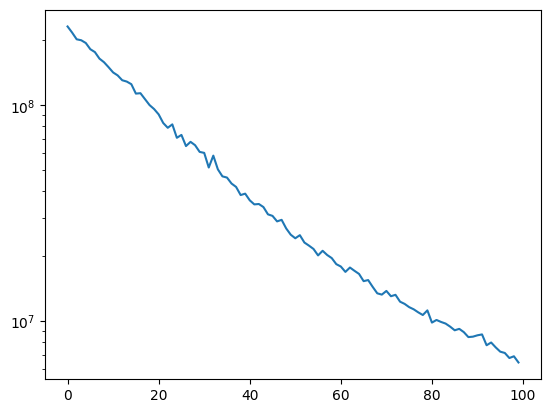

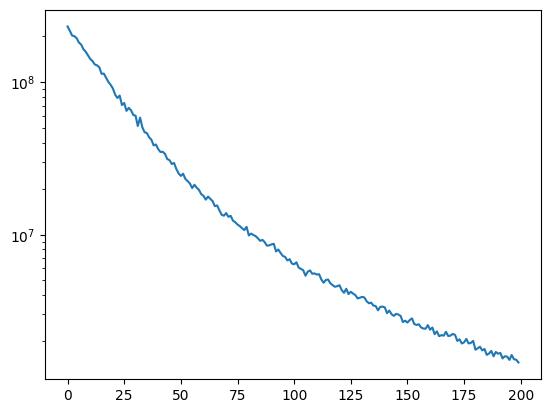

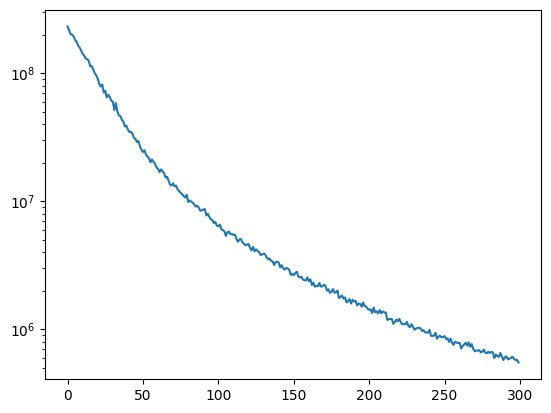

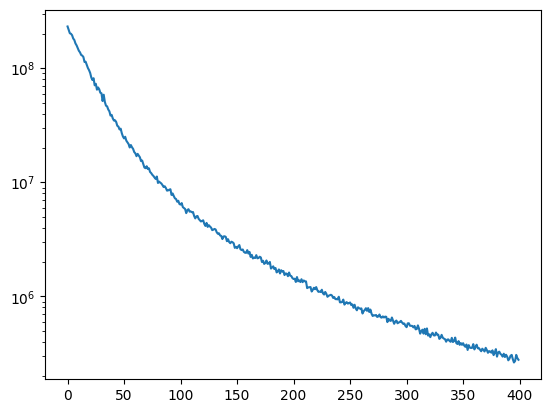

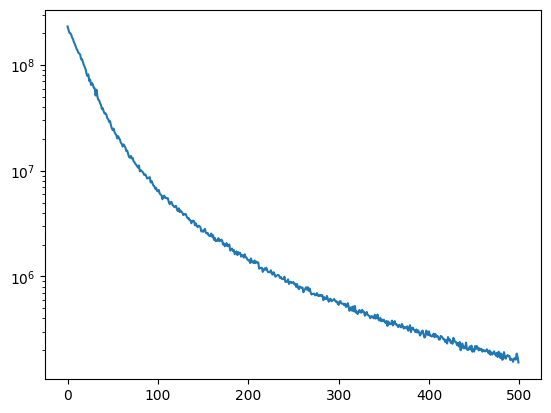

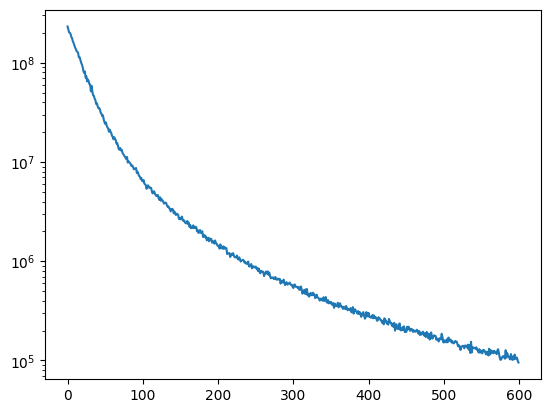

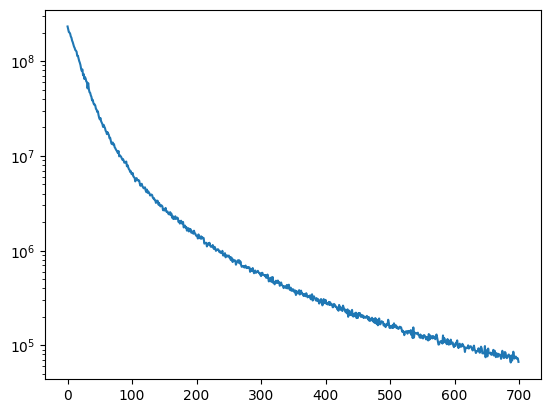

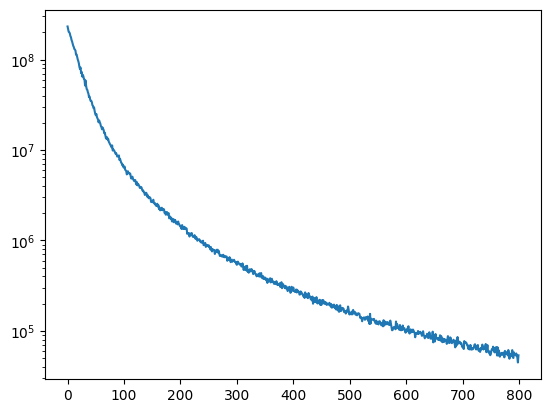

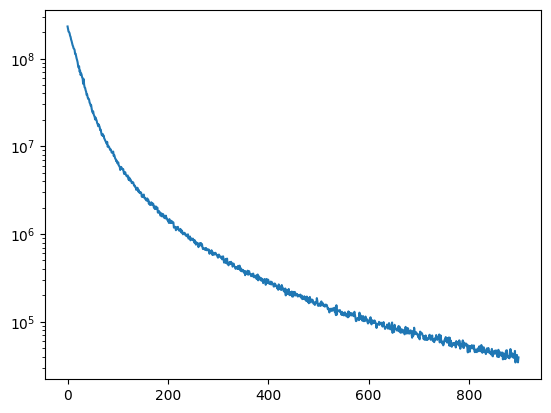

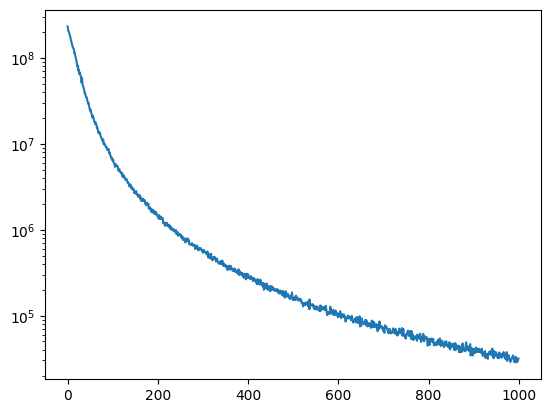

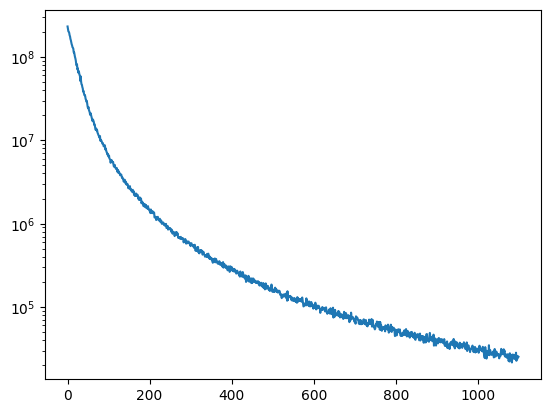

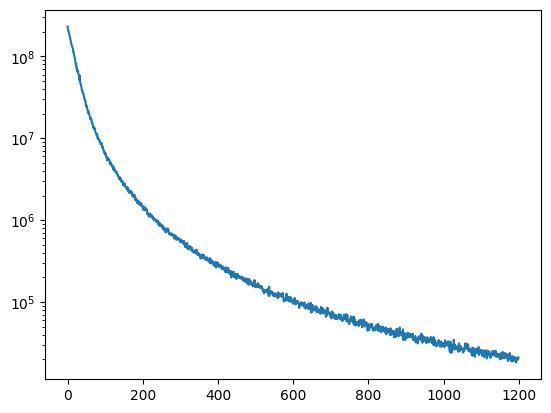

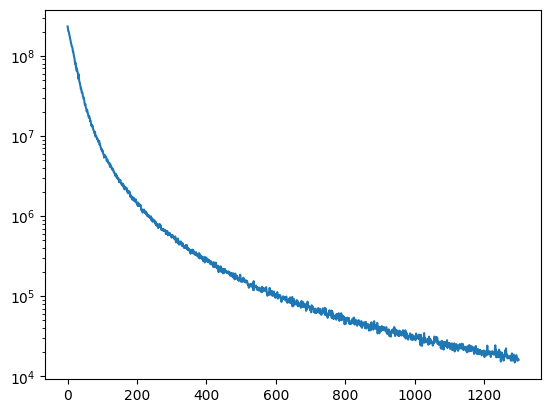

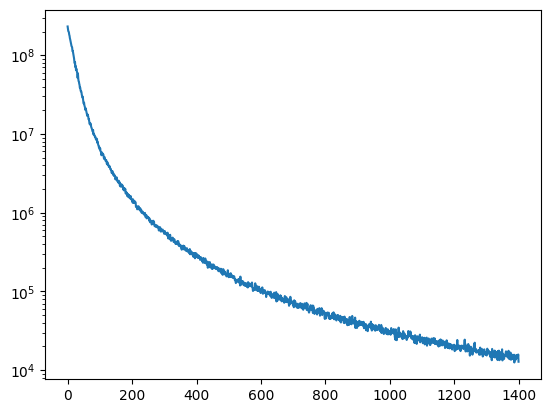

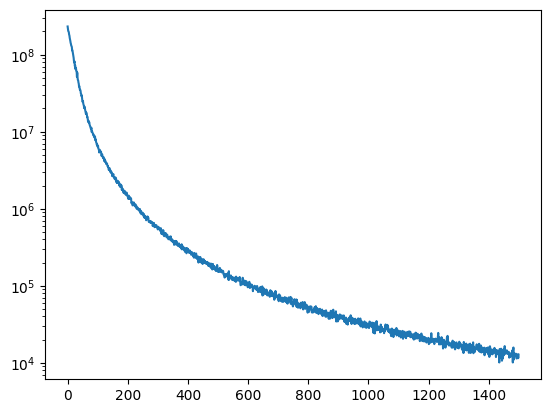

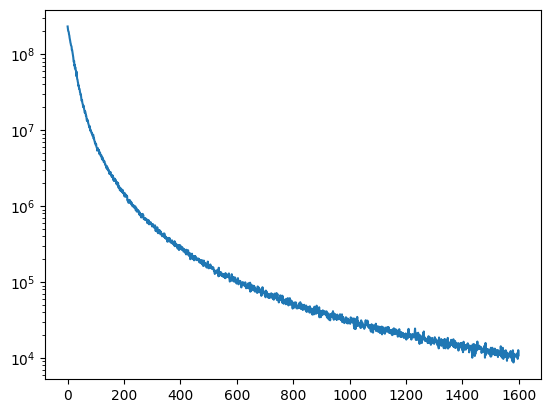

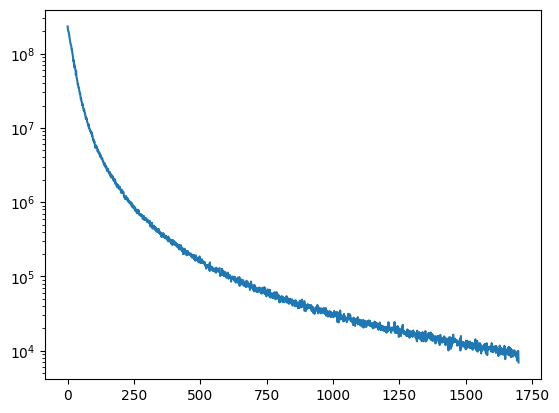

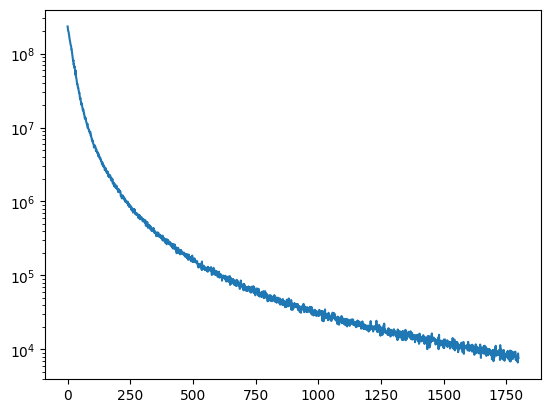

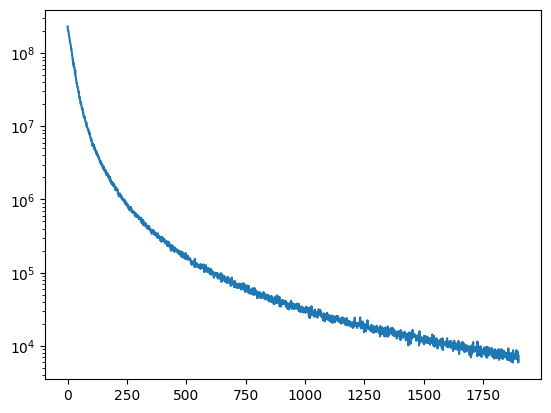

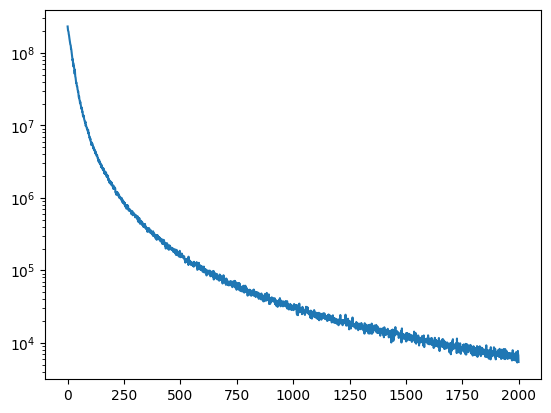

In [22]:
optimizer = torch.optim.Adam(tfp.parameters(), lr=1e-2)

n_training = 2000
check_every = 1
plot_every = 100


def complex_mse_loss(output, target):
    err = (output - target)
    return (err * err.conj()).real.sum()

def l2norm(v):
    return (v * v.conj()).real.sum()

t_vec_gen = 0
t_cost_compute = 0
t_train = 0

vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)
vec_coarse = tfp.v_project(torch.stack([vec]))

loss = np.zeros(n_training)
for t in range(1, n_training+1):
    t_start = time.perf_counter_ns()
    vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)
    
    norm = l2norm(vec)
    vec = vec / norm

    prvec = mg.v_prolong(mg.v_project(vec))

    vec2 = torch.rand_like(vec)
    vec2 = mg.v_prolong(mg.v_project(vec2))
    vec2 = vec2 / l2norm(vec2)

    vec3 = torch.rand_like(vec_coarse)
    vec3 = vec3 / l2norm(vec3)
    t_stop = time.perf_counter_ns()
    t_vec_gen = (t_stop - t_start) / 1000**2
    #print("TRAINING VECTOR GEN OK")

    t_start = time.perf_counter_ns()
    score1 = complex_mse_loss(tfp.v_prolong(tfp.v_project(torch.stack([vec]))), torch.stack([prvec]))
    score2 = complex_mse_loss(tfp.v_prolong(tfp.v_project(torch.stack([vec2]))), torch.stack([vec2]))
    score3 = complex_mse_loss(tfp.v_project(tfp.v_prolong(vec3)), vec3)
    score = score1 + score2 + score3
    t_stop = time.perf_counter_ns()
    #print("SCORE F GEN OK")

    t_cost_compute = (t_stop - t_start) / 1000**2
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] {score.item():.3e} ({t_vec_gen:.3f} + {t_cost_compute:.3f} + {t_train:.3f})", end="\r")
    loss[t-1] = score.item()

    t_start = time.perf_counter_ns()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    t_stop = time.perf_counter_ns()
    t_train = (t_stop - t_start) / 1000**2
    
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] {score.item():.3e} ({t_vec_gen:.3f} + {t_cost_compute:.3f} + {t_train:.3f})", end="\r")
    if t % plot_every == 0:
        plt.plot(loss[0:t])
        plt.yscale("log")

        plt.show()

In [23]:
def coarse_operator(transport_pooling: v_ProjectLayer, op):
    def operator(vec):
        return transport_pooling.v_project(
            torch.stack([op(
                transport_pooling.v_prolong(torch.stack([vec]))[0])
                        ])
        )[0]
    return operator

In [24]:
def arnoldi_k(A, qprev, Hprev, k):
    innerproduct = lambda x,y: (x.conj() * y).sum()
    if hasattr(A, "__call__"):
        qk = A(qprev[k-1])
    else:
        qk = A @ qprev[k-1]

    for j in range(k):
        Hprev[j, k-1] = innerproduct(qprev[j], qk)
        qk = qk - Hprev[j, k-1] * qprev[j]
    Hprev[k, k-1] = innerproduct(qk, qk)**0.5
    qk /= Hprev[k, k-1]
    qprev[k] = qk
    return qprev, Hprev

def arnoldi(A, n, q0):
    if n < 1:
        raise ValueError("nothing to do")
    H = np.zeros((n+1, n), dtype=complex)
    # This is Q^T because the shape of the
    # vectors is not known.
    q = [q0] + [None]*n

    for k in range(1, n+1):
        q, H = arnoldi_k(A, q, H, k)

    return q, H

In [25]:
with torch.no_grad():
    v_coarse = tfp.v_project(torch.stack([vec]))[0]
    
    w = dirac_wilson_clover(U, -0.58, 1.0)
    w_coarse = coarse_operator(tfp, w)
    
    q, H = arnoldi(w_coarse, 385, v_coarse)

In [26]:
evals, evec = np.linalg.eig(H[:-1])

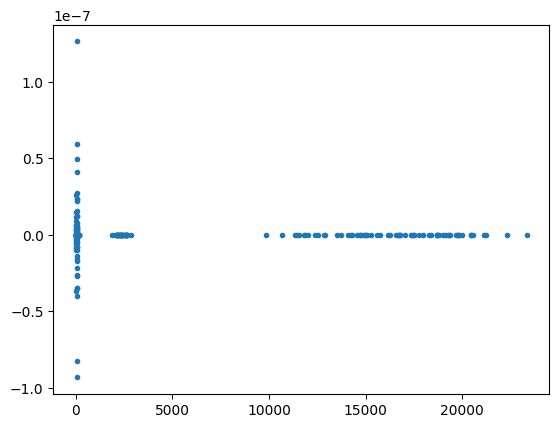

In [27]:
plt.plot(evals.real, evals.imag, ".")

(-1.0, 100.0)

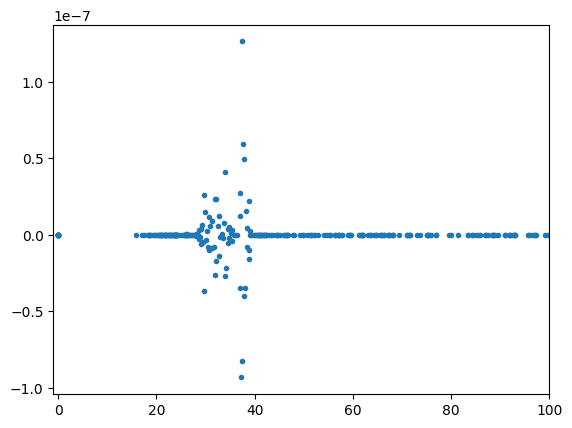

In [28]:
plt.plot(evals.real, evals.imag, ".")
plt.xlim(-1, 100)

In [29]:
tfp.v_project(torch.stack([src]))

tensor([[[[[[[ 5.0342e+01+2.2184j, -3.1894e+01+14.3866j,  1.7568e+01-12.0019j],
             [ 4.1688e+01+3.4305j, -2.3856e+01+14.3294j,  1.4653e+01-14.9950j],
             [ 4.0810e+01+5.6349j, -3.3255e+01+14.4551j,  1.6457e+01-11.6597j],
             [ 4.9142e+01+2.2422j, -2.9032e+01+9.3968j,  1.6706e+01-11.1361j]],

            [[ 1.1402e+01-2.7145j,  3.1517e+01+23.0036j, -2.2160e+01-14.4161j],
             [ 6.8403e+00-5.6717j,  3.0203e+01+20.9390j, -3.0644e+01-12.0383j],
             [ 3.2798e+00-3.7601j,  2.8839e+01+24.4718j, -2.7495e+01-13.4093j],
             [ 9.7313e+00-10.1208j,  3.6238e+01+23.7151j, -2.2975e+01-12.0838j]],

            [[-2.0533e+01+29.7689j,  1.1800e+00+18.7921j, -3.3342e+00-25.2569j],
             [-2.0968e+01+27.3779j,  7.7848e+00+20.2312j, -3.7430e+00-25.1161j],
             [-1.9036e+01+31.5878j,  2.3602e+00+15.0686j, -7.2917e+00-27.0684j],
             [-1.5807e+01+27.8336j,  2.2695e+00+17.6482j, -4.7630e+00-11.0842j]],

            [[-2.8933e+01+18.0

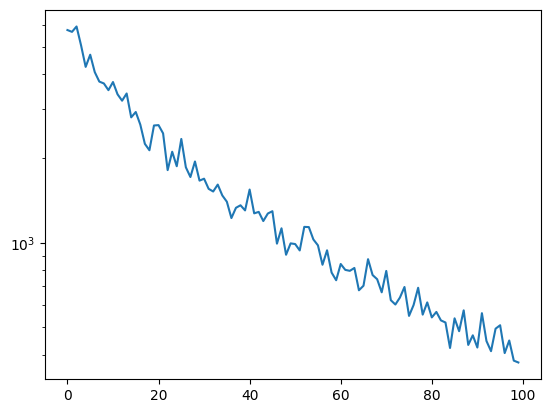

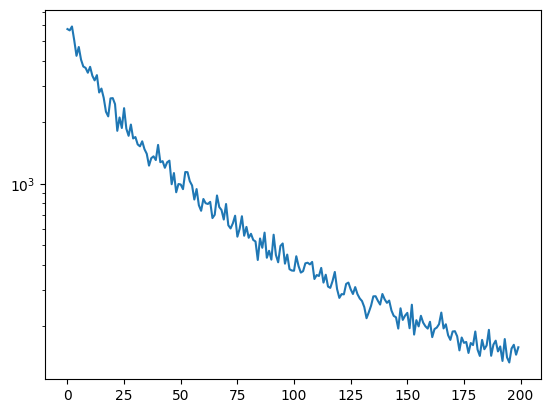

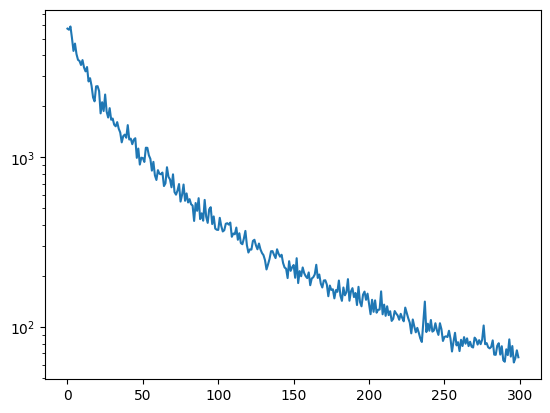

In [ ]:
optimizer = torch.optim.Adam(tfp.parameters(), lr=5e-3)

n_training = 2000
check_every = 1
plot_every = 100


def complex_mse_loss(output, target):
    err = (output - target)
    return (err * err.conj()).real.sum()

def l2norm(v):
    return (v * v.conj()).real.sum()

t_vec_gen = 0
t_cost_compute = 0
t_train = 0

vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)
vec_coarse = tfp.v_project(torch.stack([vec]))

loss = np.zeros(n_training)
for t in range(1, n_training+1):
    t_start = time.perf_counter_ns()
    vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)
    
    norm = l2norm(vec)
    vec = vec / norm

    prvec = mg.v_prolong(mg.v_project(vec))

    vec2 = torch.rand_like(vec)
    vec2 = mg.v_prolong(mg.v_project(vec2))
    vec2 = vec2 / l2norm(vec2)

    vec3 = torch.rand_like(vec_coarse)
    vec3 = vec3 / l2norm(vec3)
    t_stop = time.perf_counter_ns()
    t_vec_gen = (t_stop - t_start) / 1000**2
    #print("TRAINING VECTOR GEN OK")

    t_start = time.perf_counter_ns()
    score1 = complex_mse_loss(tfp.v_prolong(tfp.v_project(torch.stack([vec]))), torch.stack([prvec]))
    score2 = complex_mse_loss(tfp.v_prolong(tfp.v_project(torch.stack([vec2]))), torch.stack([vec2]))
    score3 = complex_mse_loss(tfp.v_project(tfp.v_prolong(vec3)), vec3)
    score = score1 + score2 + score3
    t_stop = time.perf_counter_ns()
    #print("SCORE F GEN OK")

    t_cost_compute = (t_stop - t_start) / 1000**2
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] {score.item():.3e} ({t_vec_gen:.3f} + {t_cost_compute:.3f} + {t_train:.3f})", end="\r")
    loss[t-1] = score.item()

    t_start = time.perf_counter_ns()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    t_stop = time.perf_counter_ns()
    t_train = (t_stop - t_start) / 1000**2
    
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] {score.item():.3e} ({t_vec_gen:.3f} + {t_cost_compute:.3f} + {t_train:.3f})", end="\r")
    if t % plot_every == 0:
        plt.plot(loss[0:t])
        plt.yscale("log")

        plt.show()

In [ ]:
with torch.no_grad():
    v_coarse = tfp.v_project(torch.stack([vec]))[0]
    
    w = dirac_wilson_clover(U, -0.58, 1.0)
    w_coarse = coarse_operator(tfp, w)
    
    q, H = arnoldi(w_coarse, 385, v_coarse)

In [ ]:
evals, evec = np.linalg.eig(H[:-1])

In [ ]:
plt.plot(evals.real, evals.imag, ".")

In [ ]:
optimizer = torch.optim.Adam(tfp.parameters(), lr=1e-3)

n_training = 2000
check_every = 1
plot_every = 100


def complex_mse_loss(output, target):
    err = (output - target)
    return (err * err.conj()).real.sum()

def l2norm(v):
    return (v * v.conj()).real.sum()

t_vec_gen = 0
t_cost_compute = 0
t_train = 0

vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)
vec_coarse = tfp.v_project(torch.stack([vec]))

loss = np.zeros(n_training)
for t in range(1, n_training+1):
    t_start = time.perf_counter_ns()
    vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)
    
    norm = l2norm(vec)
    vec = vec / norm

    prvec = mg.v_prolong(mg.v_project(vec))

    vec2 = torch.rand_like(vec)
    vec2 = mg.v_prolong(mg.v_project(vec2))
    vec2 = vec2 / l2norm(vec2)

    vec3 = torch.rand_like(vec_coarse)
    vec3 = vec3 / l2norm(vec3)
    t_stop = time.perf_counter_ns()
    t_vec_gen = (t_stop - t_start) / 1000**2
    #print("TRAINING VECTOR GEN OK")

    t_start = time.perf_counter_ns()
    score1 = complex_mse_loss(tfp.v_prolong(tfp.v_project(torch.stack([vec]))), torch.stack([prvec]))
    score2 = complex_mse_loss(tfp.v_prolong(tfp.v_project(torch.stack([vec2]))), torch.stack([vec2]))
    score3 = complex_mse_loss(tfp.v_project(tfp.v_prolong(vec3)), vec3)
    score = score1 + score2 + score3
    t_stop = time.perf_counter_ns()
    #print("SCORE F GEN OK")

    t_cost_compute = (t_stop - t_start) / 1000**2
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] {score.item():.3e} ({t_vec_gen:.3f} + {t_cost_compute:.3f} + {t_train:.3f})", end="\r")
    loss[t-1] = score.item()

    t_start = time.perf_counter_ns()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    t_stop = time.perf_counter_ns()
    t_train = (t_stop - t_start) / 1000**2
    
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] {score.item():.3e} ({t_vec_gen:.3f} + {t_cost_compute:.3f} + {t_train:.3f})", end="\r")
    if t % plot_every == 0:
        plt.plot(loss[0:t])
        plt.yscale("log")

        plt.show()

In [ ]:
with torch.no_grad():
    v_coarse = tfp.v_project(torch.stack([vec]))[0]
    
    w = dirac_wilson_clover(U, -0.58, 1.0)
    w_coarse = coarse_operator(tfp, w)
    
    q, H = arnoldi(w_coarse, 385, v_coarse)

In [ ]:
evals, evec = np.linalg.eig(H[:-1])

In [ ]:
plt.plot(evals.real, evals.imag, ".")

In [ ]:
optimizer = torch.optim.Adam(tfp.parameters(), lr=.5e-3)

n_training = 2000
check_every = 1
plot_every = 100


def complex_mse_loss(output, target):
    err = (output - target)
    return (err * err.conj()).real.sum()

def l2norm(v):
    return (v * v.conj()).real.sum()

t_vec_gen = 0
t_cost_compute = 0
t_train = 0

vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)
vec_coarse = tfp.v_project(torch.stack([vec]))

loss = np.zeros(n_training)
for t in range(1, n_training+1):
    t_start = time.perf_counter_ns()
    vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)
    
    norm = l2norm(vec)
    vec = vec / norm

    prvec = mg.v_prolong(mg.v_project(vec))

    vec2 = torch.rand_like(vec)
    vec2 = mg.v_prolong(mg.v_project(vec2))
    vec2 = vec2 / l2norm(vec2)

    vec3 = torch.rand_like(vec_coarse)
    vec3 = vec3 / l2norm(vec3)
    t_stop = time.perf_counter_ns()
    t_vec_gen = (t_stop - t_start) / 1000**2
    #print("TRAINING VECTOR GEN OK")

    t_start = time.perf_counter_ns()
    score1 = complex_mse_loss(tfp.v_prolong(tfp.v_project(torch.stack([vec]))), torch.stack([prvec]))
    score2 = complex_mse_loss(tfp.v_prolong(tfp.v_project(torch.stack([vec2]))), torch.stack([vec2]))
    score3 = complex_mse_loss(tfp.v_project(tfp.v_prolong(vec3)), vec3)
    score = score1 + score2 + score3
    t_stop = time.perf_counter_ns()
    #print("SCORE F GEN OK")

    t_cost_compute = (t_stop - t_start) / 1000**2
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] {score.item():.3e} ({t_vec_gen:.3f} + {t_cost_compute:.3f} + {t_train:.3f})", end="\r")
    loss[t-1] = score.item()

    t_start = time.perf_counter_ns()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    t_stop = time.perf_counter_ns()
    t_train = (t_stop - t_start) / 1000**2
    
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] {score.item():.3e} ({t_vec_gen:.3f} + {t_cost_compute:.3f} + {t_train:.3f})", end="\r")
    if t % plot_every == 0:
        plt.plot(loss[0:t])
        plt.yscale("log")

        plt.show()

In [ ]:
with torch.no_grad():
    v_coarse = tfp.v_project(torch.stack([vec]))[0]
    
    w = dirac_wilson_clover(U, -0.58, 1.0)
    w_coarse = coarse_operator(tfp, w)
    
    q, H = arnoldi(w_coarse, 385, v_coarse)

In [ ]:
evals, evec = np.linalg.eig(H[:-1])

In [ ]:
plt.plot(evals.real, evals.imag, ".")

In [ ]:
def coarse_operator_mg(mg: ZPP_Multigrid, op):
    def operator(vec):
        return mg.v_project(
            op(
                mg.v_prolong(vec))
        )
    return operator

In [ ]:
with torch.no_grad():
    v_coarse = mg.v_project(vec)
    
    w = dirac_wilson_clover(U, -0.58, 1.0)
    w_coarse = coarse_operator_mg(mg, w)
    
    q, H = arnoldi(w_coarse, 385, v_coarse)

In [ ]:
evals, evec = np.linalg.eig(H[:-1])
plt.plot(evals.real, evals.imag, ".")

In [ ]:
optimizer = torch.optim.Adam(tfp.parameters(), lr=.5e-3)

n_training = 2000
check_every = 1
plot_every = 100


def complex_mse_loss(output, target):
    err = (output - target)
    return (err * err.conj()).real.sum()

def l2norm(v):
    return (v * v.conj()).real.sum()

t_vec_gen = 0
t_cost_compute = 0
t_train = 0

vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)
vec_coarse = tfp.v_project(torch.stack([vec]))

loss = np.zeros(n_training)
for t in range(1, n_training+1):
    t_start = time.perf_counter_ns()
    vec = torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.cdouble)
    
    norm = l2norm(vec)
    vec = vec / norm

    prvec = mg.v_prolong(mg.v_project(vec))

    vec2 = torch.rand_like(vec)
    vec2 = mg.v_prolong(mg.v_project(vec2))
    vec2 = vec2 / l2norm(vec2)

    vec3 = torch.rand_like(vec_coarse)
    vec3 = vec3 / l2norm(vec3)
    t_stop = time.perf_counter_ns()
    t_vec_gen = (t_stop - t_start) / 1000**2
    #print("TRAINING VECTOR GEN OK")

    t_start = time.perf_counter_ns()
    score1 = complex_mse_loss(tfp.v_prolong(tfp.v_project(torch.stack([vec]))), torch.stack([prvec]))
    score2 = complex_mse_loss(tfp.v_prolong(tfp.v_project(torch.stack([vec2]))), torch.stack([vec2]))
    score3 = complex_mse_loss(tfp.v_project(tfp.v_prolong(vec3)), vec3)
    score = score1 + score2 + score3
    t_stop = time.perf_counter_ns()
    #print("SCORE F GEN OK")

    t_cost_compute = (t_stop - t_start) / 1000**2
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] {score.item():.3e} ({t_vec_gen:.3f} + {t_cost_compute:.3f} + {t_train:.3f})", end="\r")
    loss[t-1] = score.item()

    t_start = time.perf_counter_ns()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    t_stop = time.perf_counter_ns()
    t_train = (t_stop - t_start) / 1000**2
    
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] {score.item():.3e} ({t_vec_gen:.3f} + {t_cost_compute:.3f} + {t_train:.3f})", end="\r")
    if t % plot_every == 0:
        plt.plot(loss[0:t])
        plt.yscale("log")

        plt.show()

In [ ]:
with torch.no_grad():
    v_coarse = tfp.v_project(torch.stack([vec]))[0]
    
    w = dirac_wilson_clover(U, -0.58, 1.0)
    w_coarse = coarse_operator(tfp, w)
    
    q, H = arnoldi(w_coarse, 385, v_coarse)

In [ ]:
evals, evec = np.linalg.eig(H[:-1])

In [ ]:
plt.plot(evals.real, evals.imag, ".")